# Refer /Keras /1. preProcess with keras

In [1]:
import os
from tqdm import tqdm
import pandas as pd 
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, GRU,LSTM, Embedding,Flatten, Dropout,CuDNNGRU
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

import pickle
import h5py

from tensorflow.keras.callbacks import TensorBoard


PROJ_NAME= "1.2 Reprod_seed_drop_GRU"
tensorboard = TensorBoard(log_dir=f'logs/,{PROJ_NAME}/')

Using TensorFlow backend.


# making it reproducable

In [2]:
seed = 7

np.random.seed(seed)
from tensorflow import set_random_seed
set_random_seed(seed)

In [3]:
INPUT_TEXT_LENGTH = 695 # from previous notebook
# vocab size needs to be taken care off

In [4]:
df_preprocessed = pd.read_pickle("./pickles/1_processed_pos_tag.pkl")

In [5]:
df_preprocessed.head()

,review,word_count,sentiment
0,plot two teen couple go church party drink dri...,358,0.0
1,happy bastard 's quick movie review damn y2k b...,144,0.0
2,movie like make jaded movie viewer thankful in...,276,0.0
3,`` quest camelot `` warner bros first feature-...,313,0.0
4,synopsis mentally unstable man undergo psychot...,402,0.0


In [6]:
VOCAB_SIZE = 10000

# Vectorising usin Keras
- Setting integer value to a string token

In [7]:
%%time 
# create the tokenizer
tokenizer =Tokenizer(VOCAB_SIZE)
# fit the tokenizer on the documents
tokenizer.fit_on_texts(df_preprocessed["review"])

Wall time: 547 ms


In [8]:
#oredered as per max. freq
len(tokenizer.word_index)

34094

In [9]:
'''
# lookin abv result i feel numbers 1,2,3.. and 2char word like = ll,1char word like = x,y,z ' we can remove it
#provided we use cNN or ... maybe but not sure
# i'm not sure though its effect on LSTM network
'''

"\n# lookin abv result i feel numbers 1,2,3.. and 2char word like = ll,1char word like = x,y,z ' we can remove it\n#provided we use cNN or ... maybe but not sure\n# i'm not sure though its effect on LSTM network\n"

# Deciding Vocabulary for EMB. matrix

In [10]:
#len(tokenizer.word_index)
tokenizer.word_index

{"'s": 1,
 'film': 2,
 'movie': 3,
 "n't": 4,
 'one': 5,
 'make': 6,
 'like': 7,
 'character': 8,
 'get': 9,
 'see': 10,
 'go': 11,
 'time': 12,
 'good': 13,
 'even': 14,
 'scene': 15,
 'well': 16,
 'story': 17,
 'would': 18,
 'play': 19,
 'take': 20,
 'much': 21,
 'also': 22,
 'come': 23,
 'give': 24,
 'two': 25,
 'way': 26,
 'know': 27,
 'first': 28,
 'bad': 29,
 'seem': 30,
 'look': 31,
 'end': 32,
 'life': 33,
 'year': 34,
 'work': 35,
 'thing': 36,
 'could': 37,
 'plot': 38,
 'say': 39,
 'find': 40,
 'really': 41,
 'little': 42,
 'show': 43,
 'people': 44,
 'man': 45,
 'think': 46,
 'never': 47,
 'star': 48,
 'love': 49,
 'director': 50,
 'great': 51,
 'best': 52,
 'new': 53,
 'try': 54,
 'performance': 55,
 'big': 56,
 'many': 57,
 'action': 58,
 'actor': 59,
 'u': 60,
 'want': 61,
 'watch': 62,
 'role': 63,
 'another': 64,
 'use': 65,
 'back': 66,
 'become': 67,
 'audience': 68,
 'world': 69,
 'something': 70,
 'still': 71,
 'act': 72,
 'day': 73,
 'turn': 74,
 "'re": 75,
 'howe

# Converting text data to abv to integer values

In [11]:
%%time
seq = tokenizer.texts_to_sequences(df_preprocessed["review"])

Wall time: 453 ms


# Check for values

In [12]:
 df_preprocessed['review'][1]

"happy bastard 's quick movie review damn y2k bug 's got head start movie star jamie lee curtis another baldwin brother william time story regard crew tugboat come across deserted russian tech ship strangeness kick power back little know power within go gore bring action sequence virus still feel empty like movie go flash substance n't know crew really middle nowhere n't know origin take ship big pink flashy thing hit mir course n't know donald sutherland stumble around drunkenly throughout 's `` hey let 's chase people around robot `` acting average even like curtis 're likely get kick work halloween h20 sutherland waste baldwin well 's act like baldwin course real star stan winston 's robot design schnazzy cgi occasional good gore shot like pick someone 's brain robot body part really turn 's movie otherwise 's pretty much sunken ship movie"

In [13]:
np.array(seq[1])

array([ 544, 2388,    1,  890,    3,  264, 1095,  943,    1, 4785,  181,
        119,    3,   48, 2666,  442, 2961,   64, 1400,  234,  588,   12,
         17, 1847,  555,   23,  538, 1541, 3416,  395, 1022,  320,   66,
         42,   27,  320,  524,   11, 1153,  178,   58,  139, 1560,   71,
        104, 1783,    7,    3,   11, 1414, 1615,    4,   27,  555,   41,
        531, 1289,    4,   27, 6713,   20,  395,   56, 4198, 2667,   36,
        280, 9313,  141,    4,   27, 2886, 2814, 1542,   88,  389,    1,
       1742,  187,    1,  441,   44,   88, 1802, 1561, 1063,   14,    7,
       2961,   75,  743,    9, 1022,   35, 2094, 8609, 2814,  434, 1400,
         16,    1,   72,    7, 1400,  141,   83,   48, 6714,    1, 1802,
        812, 2294, 1923,   13, 1153,  214,    7,  593,  279,    1, 1023,
       1802,  368,   81,   41,   74,    1,    3,  795,    1,  192,   21,
        395,    3])

In [14]:
'''
WE CAN SEE THE DIFFERENCE 10 , BCOZ OTHER VALUES ARE GRATER THEN 10000 SO ITS NOT CONSIDERED
'''
print(df_preprocessed['word_count'][1])
print(len(np.array(seq[1])))

144
134


In [15]:
print(" Actual VOCAB_SIZE deined: ",VOCAB_SIZE)
print(" Actual tokens created: ",len(tokenizer.word_index))# IF WE WANT TO CONSIDER EVERY TEXT IN VOCAB PASS THIS

 Actual VOCAB_SIZE deined:  10000
 Actual tokens created:  34094


# Padding and Truncating Data
* To feed it to N.N, inputs to have the same length
 - Either we ensure that all sequences in the entire data-set have the same length
 - Or Entier batch should be of same length
* Going about choosing ampunt to pad
 - going with longest seq, would be just waste of memory for texr whose length is small
 - going with smalles seq , would be just ignoring other imp values 
 - so we go optimal


In [16]:
'''
All that the Embedding layer does is to map the integer inputs to the vectors found at the corresponding index in the 
embedding matrix, i.e. the sequence [1, 2] would be converted to [embeddings[1], embeddings[2]]
'''
print(np.array(seq[506]))

[   2 5595 6919  146   11  434  240]


# Padding and trucating here

In [17]:
imdb_data_pad = sequence.pad_sequences(seq , maxlen=INPUT_TEXT_LENGTH,padding='pre', truncating='pre')

In [18]:
imdb_data_pad.shape
# 2k review
# and 695 fixed I/P shape

(2000, 695)

In [19]:
#checking
#imdb_data_pad[4]
type(seq)

list

In [20]:
tokenizer

# Tokenizer Inverse Map

In [21]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [22]:

def tokens_to_string(tokens):
    # Map from tokens back to words.
    words = [inverse_map[token] for token in tokens if token != 0]
    
    # Concatenate all words.
    text = " ".join(words)

    return text

In [23]:
tokens_to_string(seq[506])

"film extraordinarily horrendous 'm go waste word"

In [24]:
# N.N Model
len(tokenizer.word_index) # This are total word in dict
#it depends if i want to use entier dict or only few occuring word

34094

# Split data to test/ train / dev (disabled for train test split )

In [25]:
X= imdb_data_pad #PADDED VERSION OF DATA
y= df_preprocessed['sentiment'] # LABELS OF DATA

X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.33, random_state=42)

# CREATING A MODEL
* http://fizzylogic.nl/2017/05/08/monitor-progress-of-your-keras-based-neural-network-using-tensorboard/

In [26]:
%%time
model = Sequential()
                   #vocab_size
model.add(Embedding(VOCAB_SIZE, 50, input_length=INPUT_TEXT_LENGTH))

'''
embedding_layer = Embedding(VOCAB_SIZE, 50, weights=[embedding_matrix], input_length=INPUT_TEXT_LENGTH, trainable=False)
model.add(embedding_layer)
model.add(Dropout(0.2))
'''
model.add(CuDNNGRU(units=16, return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNGRU(units=8, return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNGRU(units=4))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 695, 50)           500000    
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 695, 16)           3264      
_________________________________________________________________
dropout_1 (Dropout)          (None, 695, 16)           0         
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 695, 8)            624       
_________________________________________________________________
dropout_2 (Dropout)          (None, 695, 8)            0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 4)                 168       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total para

# print out model image

In [27]:
from keras.utils import plot_model
import os
#install graph viz locally 1st
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'# install 
plot_model(model, to_file=f'model_images/{PROJ_NAME}.png')

# fitting model with validation data

In [28]:
history = model.fit(X, y, epochs=4 , validation_data=(X_val, y_val),verbose=2, shuffle=False, callbacks=[tensorboard])

Train on 2000 samples, validate on 660 samples
Epoch 1/4
 - 29s - loss: 0.7964 - acc: 0.4910 - val_loss: 0.6872 - val_acc: 0.4924
Epoch 2/4
 - 13s - loss: 0.7034 - acc: 0.5255 - val_loss: 0.6737 - val_acc: 0.9030
Epoch 3/4


C:\Users\DBCE\Anaconda3\envs\tf_gpu\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.077905). Check your callbacks.
  % delta_t_median)
C:\Users\DBCE\Anaconda3\envs\tf_gpu\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.562383). Check your callbacks.
  % delta_t_median)


 - 11s - loss: 0.6884 - acc: 0.5725 - val_loss: 0.6399 - val_acc: 0.7712
Epoch 4/4
 - 10s - loss: 0.6384 - acc: 0.6900 - val_loss: 0.5375 - val_acc: 0.7788


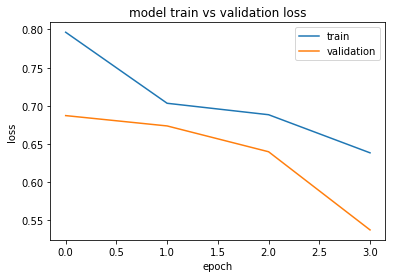

In [29]:
# plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [33]:
%%time
#history = model.fit(X_train, y_train, epochs=3, batch_size=64, verbose=2,callbacks=[tensorboard])
#model.fit(X[X_train], y[y_train], epochs=3, validation_data=(X_val, y_val), batch_size=64, verbose=2,callbacks=[tensorboard])
# use validation_split=0.08 only incase data is not been splitte earlier

# TENSORBOARD
# tensorboard --logdir logs/
# http://localhost:6006/

IndexError: index 2547 is out of bounds for axis 0 with size 2000

In [ ]:

# Final evaluation of the model
#scores = model.evaluate(X_test, y_test, verbose=0)
#print("Accuracy: %.2f%%" % (scores[1]*100))


In [ ]:
'''
Neural networks are stochastic, they can produce different results when the same model is fit on the same data.
This is mainly because of the random initial weights and the shuffling of patterns during mini-batch gradient descent. 
This means that any one scoring of a model is unreliable and we should estimate model skill based on an average of multiple runs.
'''

In [ ]:
scores

# Have to try:
* include pre trained embedding before
* set trainable param**
* other architecture
* hyperparam settings etc..

In [ ]:
#refs
#use tensorboard
# 1. https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# 2. Logloss is a very useful measure for evaluating the performance of learning algorithms on multi-class classification problems:
# 3. http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss